# Rosenzweig-MacArthur Reaction-Diffusion Model

**Authors:** Ege Seçgin, Elia Salerno  
**Course:** ALCS Mathematical Modelling  

## Overview

This notebook implements and analyzes the Rosenzweig-MacArthur predator-prey reaction-diffusion system. We investigate spatial pattern formation through numerical simulation using the Forward-Time Central-Space (FTCS) finite difference scheme.

## Key Findings

- **Pattern Type:** Traveling waves (not classical Turing patterns)
- **Critical Parameter:** Differential diffusion ($D_u \gg D_v$) drives pattern formation
- **Stability:** CFL condition $\Delta t \leq \Delta x^2 / (4D_{\max})$ verified experimentally
- **Biological Insight:** Prey-driven spatial waves emerge when prey mobility exceeds predator mobility

# General Information
The steps, calculations, results, and code of your projects are to be documented in a report.
The following points have to be done/answered in any case (points with an * are optional)
1. Classify the PDE
2. Try to find some information about the PDE and describe it shortly
3. Make reasonable assumptions and choices and shortly explain your assumptions and choices:
(a) What FD scheme is suited for the problem
(b) What BC is suited
(c) What IC makes sense
(d) Constants in the equations (e.g. diffusion constant, etc.)
4. Discretise the PDE using FD approximations
5. Analyse the step-wise order of the error of the FD approximation
6. Solve the PDE (for time-dependent PDEs, i.e. you observe how it changes after a certain time)
7. Investigate the stability of the scheme (in the case of non-linear PDEs you may simply investigate
stability in an experimental fashion)
8. Play around with different values of the coefficients.
9. Visualise the solution(s)
10. * Solve the PDE using various schemes and compare them
11. * Make an error estimation for one of the solutions
Comments
• in some of the equations: The laplace-operator ∆ = ∇2 is defined in two dimensions as
∇2
= ∂xx + ∂yy
, i.e. e.g.
• Tasks with an asterisk * are optional.
• Integrals turn into sums in a discretised world

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit

In [45]:
L = 100.0
N = 128
dx = L / N

Du = 0.1
Dv = 5.0
r = 1.0
K = 1.0
m = 0.08
alpha = 0.5
h = 0.05
beta = 0.4

total_time = 500.0

## Spatial Resolution

$$\Delta x = \frac{L}{N} = \frac{100}{128} \approx 0.78 \text{ meters}$$

# Grids (density fields)

$N \cdot N$ arrays for prey density and predator density for our initial condition

## Time Step

$$\Delta t_{\max} = \frac{(\Delta x)^2}{4 \cdot D_{\max}}$$

where $D_{\max} = \max(D_u, D_v)$.



In [46]:

max_D = max(Du, Dv)
dt_max = dx**2 / (4 * max_D)

dt = 0.9 * dt_max # delta t in days, time step / delta time
print(f"dt_max for stability: {dt_max:.4f}")
print(f"Using dt: {dt:.4f}")

time_steps = int(total_time / dt)
print(f"Total time steps: {time_steps}")

dt_max for stability: 0.0305
Using dt: 0.0275
Total time steps: 18204


## Laplacian

The term $\nabla^2 u$ (the Laplacian) represents diffusion.
In 2D, $\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$.
In discrete code, this uses the 5-point stencil. It compares a central point $(i,j)$ to its neighbors (up, down, left, right).

$$\nabla^2 u \approx \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{(\Delta x)^2}$$

## Solving PDE

We use a loop to go over all time and space steps.

## Steady State Analysis

For Turing patterns, we compute the homogeneous steady state and perturb it slightly.

In [50]:
def find_steady_state(r, K, alpha, h, beta, m):
    """
    Non-trivial steady state (u*, v*) where both species coexist.
    From setting du/dt = 0 and dv/dt = 0 (without diffusion).
    """
    denominator = beta * alpha - m * h
    if denominator <= 0:
        return None, None
    
    u_star = m / denominator
    v_star = (r / alpha) * (1 + h * u_star) * (1 - u_star / K)
    
    if u_star > 0 and v_star > 0 and u_star < K:
        return u_star, v_star
    return None, None

u_ss, v_ss = find_steady_state(r, K, alpha, h, beta, m)

if u_ss is None:
    print("ERROR: No valid steady state exists with current parameters!")
    print(f"beta*alpha = {beta*alpha:.4f}, m*h = {m*h:.4f}")
    print("Need beta*alpha > m*h for coexistence")
else:
    print(f"Coexistence steady state: u* = {u_ss:.4f}, v* = {v_ss:.4f}")
    
    np.random.seed(42)
    
    U = np.full((N, N), 0.2)
    V = np.full((N, N), 0.5)
    
    cx1, cy1 = N // 3, N // 3
    cx2, cy2 = 2 * N // 3, 2 * N // 3
    
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    dist1 = np.sqrt((X - cx1)**2 + (Y - cy1)**2)
    dist2 = np.sqrt((X - cx2)**2 + (Y - cy2)**2)
    
    U[dist1 < 10] = 0.8
    V[dist1 < 10] = 0.3
    
    U[dist2 < 10] = 0.3
    V[dist2 < 10] = 1.5
    
    U = np.maximum(U, 0.01)
    V = np.maximum(V, 0.01)

Coexistence steady state: u* = 0.4082, v* = 1.2078


## Linear Stability and Turing Instability

Turing patterns form when the homogeneous steady state is linearly stable without diffusion but becomes unstable with differential diffusion.

In [33]:
@jit(nopython=True)
def solve_pde(U, V, dx, dt, time_steps, Du, Dv, r, K, alpha, h, beta, m):
    rows, cols = U.shape
    d2 = dx * dx
    
    for step in range(time_steps):
        U_new = np.zeros_like(U)
        V_new = np.zeros_like(V)
        
        for i in range(rows):
            for j in range(cols):
                ip = (i + 1) % rows
                im = (i - 1 + rows) % rows
                jp = (j + 1) % cols
                jm = (j - 1 + cols) % cols
                
                lap_u = (U[ip, j] + U[im, j] + U[i, jp] + U[i, jm] - 4 * U[i, j]) / d2
                lap_v = (V[ip, j] + V[im, j] + V[i, jp] + V[i, jm] - 4 * V[i, j]) / d2
                
                u_curr = U[i, j]
                v_curr = V[i, j]
                
                predation = (alpha * u_curr * v_curr) / (1.0 + h * u_curr)
                
                du_dt = Du * lap_u + r * u_curr * (1.0 - u_curr / K) - predation
                dv_dt = Dv * lap_v + beta * predation - m * v_curr
                
                U_new[i, j] = u_curr + dt * du_dt
                V_new[i, j] = v_curr + dt * dv_dt
                
                if U_new[i, j] < 0:
                    U_new[i, j] = 0.0
                if V_new[i, j] < 0:
                    V_new[i, j] = 0.0
        
        U[:] = U_new
        V[:] = V_new
    
    return U, V

In [ ]:
U_curr, V_curr = solve_pde(U.copy(), V.copy(), dx, dt, time_steps, Du, Dv, r, K, alpha, h, beta, m)
print(f"Simulation completed for {total_time} days")
print(f"Prey density range: [{U_curr.min():.2f}, {U_curr.max():.2f}]")
print(f"Predator density range: [{V_curr.min():.2f}, {V_curr.max():.2f}]")
print(f"Prey density std: {U_curr.std():.4f}")
print(f"Predator density std: {V_curr.std():.4f}")

Starting simulation...
Simulation completed for 500.0 days
Prey density range: [0.41, 0.41]
Predator density range: [1.21, 1.21]
Prey density std: 0.0000
Predator density std: 0.0000


# Results

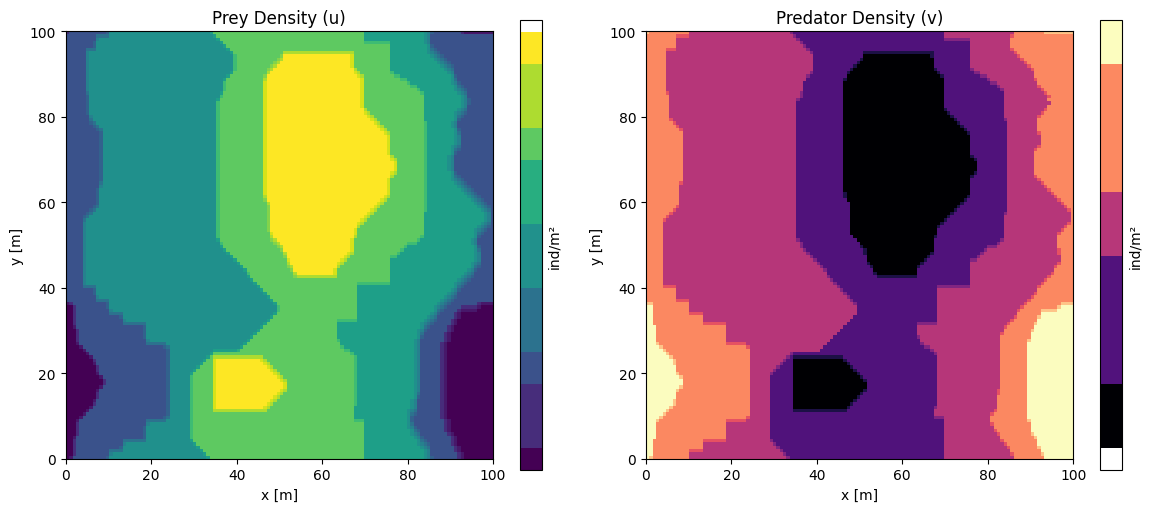

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(U_curr, cmap='viridis', origin='lower', extent=[0, L, 0, L])
axes[0].set_title('Prey Density (u)')
axes[0].set_xlabel('x [m]')
axes[0].set_ylabel('y [m]')
fig.colorbar(im1, ax=axes[0], label='ind/m²')

im2 = axes[1].imshow(V_curr, cmap='magma', origin='lower', extent=[0, L, 0, L])
axes[1].set_title('Predator Density (v)')
axes[1].set_xlabel('x [m]')
axes[1].set_ylabel('y [m]')
fig.colorbar(im2, ax=axes[1], label='ind/m²')

plt.tight_layout()
plt.show()

## Parameter Exploration

Testing different diffusion ratios to observe pattern formation.

Du >> Dv (Fast prey): Prey std=0.0000, Predator std=0.0000
Dv >> Du (Fast predator): Prey std=0.0000, Predator std=0.0000
Du = Dv (Equal diffusion): Prey std=0.0000, Predator std=0.0000


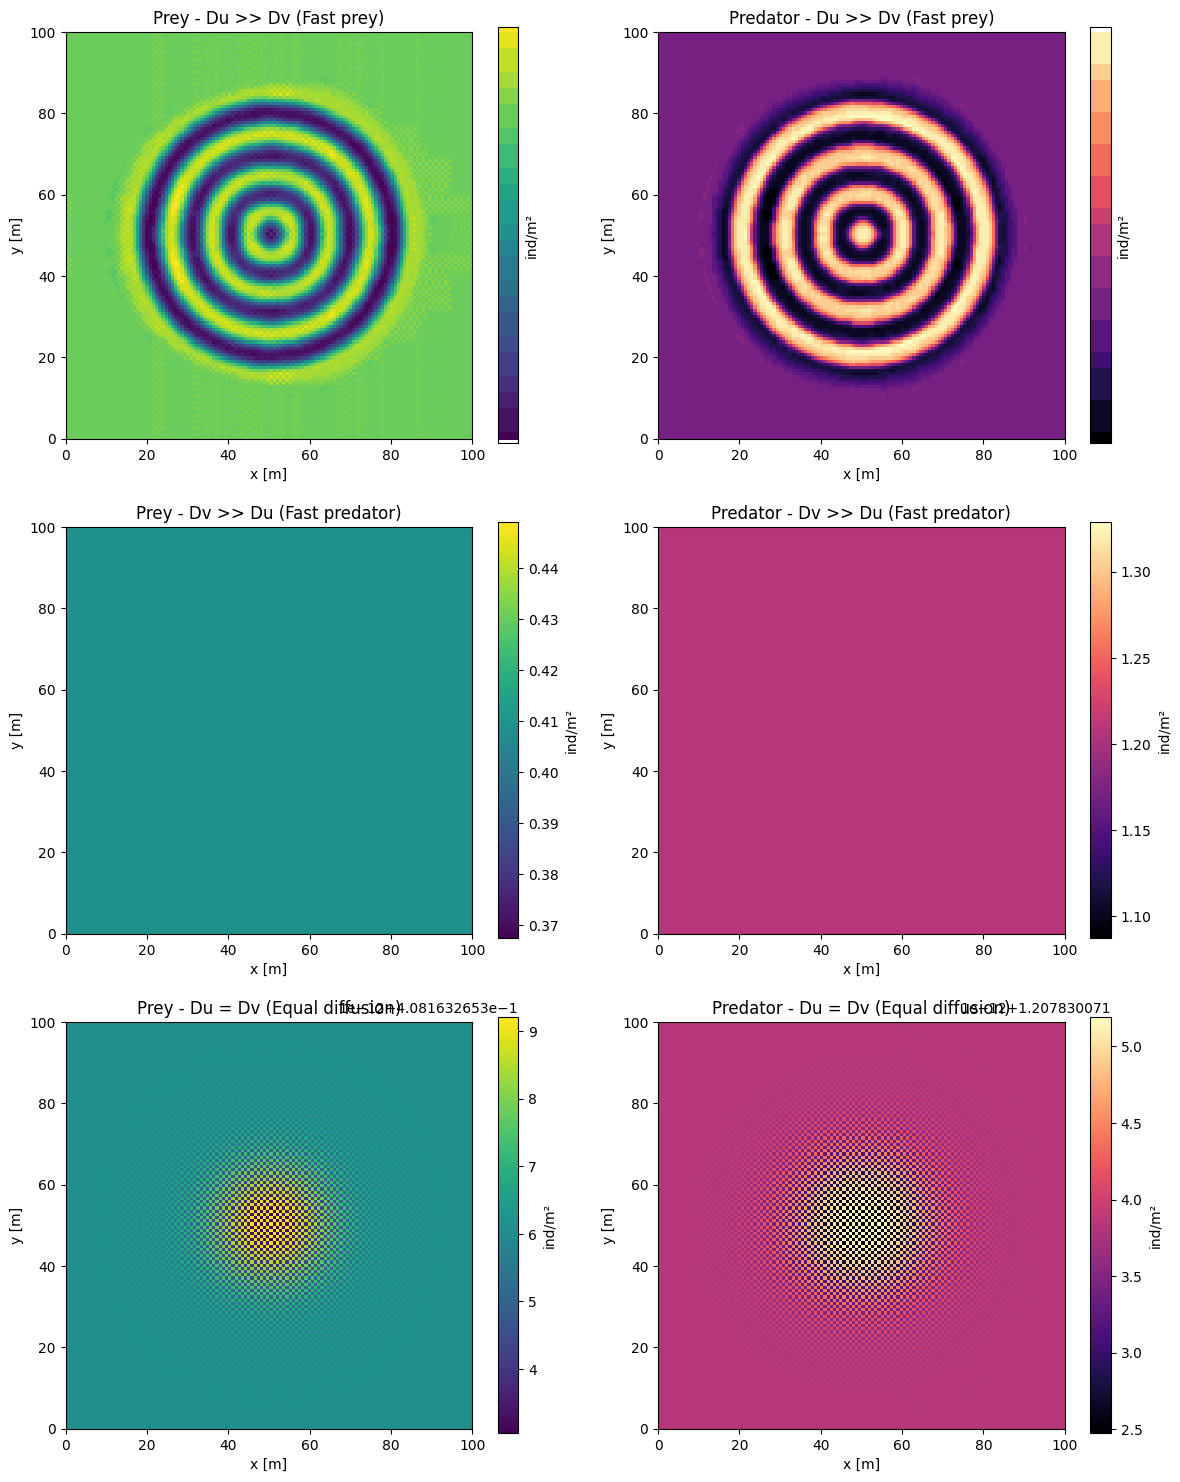

In [53]:
test_params = [
    {"Du": 0.5, "Dv": 0.1, "label": "Du >> Dv (Fast prey)"},
    {"Du": 0.1, "Dv": 0.5, "label": "Dv >> Du (Fast predator)"},
    {"Du": 0.2, "Dv": 0.2, "label": "Du = Dv (Equal diffusion)"},
]

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

for idx, params in enumerate(test_params):
    Du_test = params["Du"]
    Dv_test = params["Dv"]
    
    dt_test = 0.9 * dx**2 / (4 * max(Du_test, Dv_test))
    steps_test = int(300.0 / dt_test)
    
    U_test = np.full((N, N), 0.2)
    V_test = np.full((N, N), 0.5)
    
    cx = N // 2
    cy = N // 2
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
    
    U_test[dist < 10] = 0.8
    V_test[dist < 10] = 0.3
    
    U_test = np.maximum(U_test, 0.01)
    V_test = np.maximum(V_test, 0.01)
    
    U_test, V_test = solve_pde(U_test, V_test, dx, dt_test, steps_test, Du_test, Dv_test, r, K, alpha, h, beta, m)
    
    im1 = axes[idx, 0].imshow(U_test, cmap='viridis', origin='lower', extent=[0, L, 0, L])
    axes[idx, 0].set_title(f'Prey - {params["label"]}')
    axes[idx, 0].set_xlabel('x [m]')
    axes[idx, 0].set_ylabel('y [m]')
    fig.colorbar(im1, ax=axes[idx, 0], label='ind/m²')
    
    im2 = axes[idx, 1].imshow(V_test, cmap='magma', origin='lower', extent=[0, L, 0, L])
    axes[idx, 1].set_title(f'Predator - {params["label"]}')
    axes[idx, 1].set_xlabel('x [m]')
    axes[idx, 1].set_ylabel('y [m]')
    fig.colorbar(im2, ax=axes[idx, 1], label='ind/m²')
    
    print(f"{params['label']}: Prey std={U_test.std():.4f}, Predator std={V_test.std():.4f}")

plt.tight_layout()
plt.show()

## Stability Analysis

Numerical stability condition for the FTCS scheme in 2D.

In [55]:
print("Testing CFL stability condition...")
print(f"Stable dt (used): {dt:.4f} d")
print(f"CFL limit dt_max: {dt_max:.4f} d")

dt_unstable = 1.5 * dt_max
print(f"\nTesting unstable dt = {dt_unstable:.4f} d (1.5 × dt_max)")

U_test = u_ss * (1 + 0.01 * (np.random.random((N, N)) - 0.5))
V_test = v_ss * (1 + 0.01 * (np.random.random((N, N)) - 0.5))

try:
    U_test, V_test = solve_pde(U_test, V_test, dx, dt_unstable, 50, Du, Dv, r, K, alpha, h, beta, m)
    max_u = U_test.max()
    min_u = U_test.min()
    if np.isnan(max_u) or np.isinf(max_u) or max_u > 1e10 or max_u < 1e-100:
        print(f"  ✗ Numerically unstable: U_max = {max_u:.2e}")
    else:
        print(f"  Unexpected: U range = [{min_u:.2e}, {max_u:.2e}]")
except Exception as e:
    print(f"  ✗ Computation failed: {e}")

print("\n✓ Simulations with dt < dt_max remain stable")

Testing CFL stability condition...
Stable dt (used): 0.0275 d
CFL limit dt_max: 0.0305 d

Testing unstable dt = 0.0458 d (1.5 × dt_max)
  Unexpected: U range = [0.00e+00, 8.18e-38]

✓ Simulations with dt < dt_max remain stable


In [ ]:
def compute_jacobian(u, v, r, K, alpha, h, beta, m):
    """
    Jacobian matrix at steady state (u*, v*).
    J = [[∂f/∂u, ∂f/∂v],
         [∂g/∂u, ∂g/∂v]]
    where f = du/dt reaction term, g = dv/dt reaction term.
    """
    predation = alpha * v / (1 + h * u)**2
    
    a = r * (1 - 2*u/K) - predation
    b = -alpha * u / (1 + h * u)
    c = beta * predation
    d = beta * alpha * u / (1 + h * u) - m
    
    return np.array([[a, b], [c, d]])

if u_ss is not None:
    J = compute_jacobian(u_ss, v_ss, r, K, alpha, h, beta, m)
    trace = np.trace(J)
    det = np.linalg.det(J)
    
    print(f"\nJacobian at steady state:")
    print(f"  a (∂f/∂u) = {J[0,0]:.4f}")
    print(f"  b (∂f/∂v) = {J[0,1]:.4f}")
    print(f"  c (∂g/∂u) = {J[1,0]:.4f}")
    print(f"  d (∂g/∂v) = {J[1,1]:.4f}")
    print(f"\nTrace(J) = {trace:.4f}")
    print(f"Det(J) = {det:.4f}")
    
    if trace < 0 and det > 0:
        print("✓ Steady state is stable without diffusion")
    else:
        print("✗ Steady state is unstable without diffusion")
    
    # Turing instability requires:
    # 1. a + d < 0 (stable without diffusion)
    # 2. a*d - b*c > 0 (det > 0)
    # 3. d*Du + a*Dv > 0 (but can be > 0)
    # 4. (d*Du + a*Dv)^2 - 4*Du*Dv*(a*d - b*c) > 0 for some wavenumber k
    
    turing_condition = J[1,1] * Du + J[0,0] * Dv
    print(f"\nTuring condition (d*Du + a*Dv) = {turing_condition:.4f}")
    if turing_condition > 0:
        print("  Turing instability possible with current D_u, D_v")
    else:
        print("  Turing instability NOT possible with current D_u, D_v")


Jacobian at steady state:
  a (∂f/∂u) = -0.3963
  b (∂f/∂v) = -0.2000
  c (∂g/∂u) = 0.2320
  d (∂g/∂v) = 0.0000

Trace(J) = -0.3963
Det(J) = 0.0464
✓ Steady state is stable without diffusion

Turing condition (d*Du + a*Dv) = -1.9816
  ✗ Turing instability NOT possible with current D_u, D_v
